In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import matplotlib.pyplot as plt
import torchvision, torch, glob
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split

# Dataset

In [2]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.CenterCrop(256),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.CenterCrop(256),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ])}

data_folder = "./dataset2"

In [3]:
data = torchvision.datasets.ImageFolder(root=data_folder, transform=transform_dict['train'])

In [4]:
train_size = int(len(data) * 10 / 11)
valid_size  = len(data) - train_size      
data_size  = {"train":train_size, "valid":valid_size}
print(data_size)
data_train, data_valid = torch.utils.data.random_split(data, [train_size, valid_size])

{'train': 1020, 'valid': 102}


In [5]:
batch_size = 20
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader   = torch.utils.data.DataLoader(data_valid, batch_size=1, shuffle=False)
dataloaders  = {"train":train_loader, "valid":valid_loader}

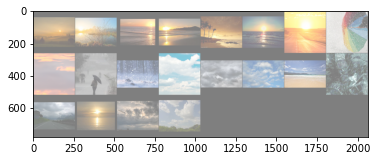

tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(2) tensor(4) tensor(2) tensor(2) tensor(3) tensor(1) tensor(1) tensor(3) tensor(2) tensor(1) tensor(4) tensor(1) tensor(1)


In [6]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 訓練データをランダムに取得
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# 画像,ラベルの表示
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

#1:cloudy, 2:rain, 3:shine, 4:sunrise

# Learning

In [7]:
class AttentionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size =2), nn.LeakyReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size =2), nn.LeakyReLU(), 
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size =2), nn.LeakyReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size =2), nn.LeakyReLU(),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64*4,5), nn.Softmax(dim=1),
        )
    def forward(self, img):
        x1 = self.conv(img)
        B,C,W,H = x1.shape
        x2 = F.adaptive_avg_pool2d(x1, (2,2))

        x3 = x2.reshape(B,-1)
        x4 = self.fc(x3)
        return x4

In [8]:
epoch = 200
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = AttentionCNN()
model.to(device)

#loss_func = nn.CrossEntropyLoss()
loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters())

Epoch:0, Train_Loss:0.07287934955720808, Valid_Loss:0.05448999330688179
Acc: 0.4803921568627451
Epoch:20, Train_Loss:0.025960668464939968, Valid_Loss:0.030148489059725104
Acc: 0.7843137254901961
Epoch:40, Train_Loss:0.02559687770610931, Valid_Loss:0.029123648560189865
Acc: 0.7941176470588235
Epoch:60, Train_Loss:0.022885390196689497, Valid_Loss:0.025206486770106895
Acc: 0.8333333333333334
Epoch:80, Train_Loss:0.02283798857573785, Valid_Loss:0.0329152593657798
Acc: 0.7843137254901961
Epoch:100, Train_Loss:0.02007221966507096, Valid_Loss:0.024284967510181003
Acc: 0.8529411764705882
Epoch:120, Train_Loss:0.018494759257152386, Valid_Loss:0.019397346696776084
Acc: 0.8627450980392157
Epoch:140, Train_Loss:0.017093302556496187, Valid_Loss:0.020732090354216165
Acc: 0.8529411764705882
Epoch:160, Train_Loss:0.01577266444242103, Valid_Loss:0.023318743915861202
Acc: 0.8529411764705882
Epoch:180, Train_Loss:0.01503850718247978, Valid_Loss:0.02196023744049239
Acc: 0.8725490196078431


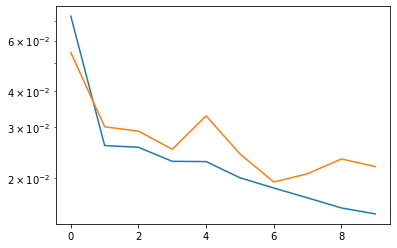

In [9]:
train_loss_list = []
valid_loss_list = []
for i in range(epoch):
    train_running_loss = 0.0
    valid_running_loss = 0.0
    for images, labels in dataloaders["train"]:
        images = images.to(device)
        labels = torch.nn.functional.one_hot(labels, num_classes=5)
        labels = labels.to(device).to(torch.float32)
        
        outputs = model(images)
        
        loss = loss_func(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
    if i % (epoch/10) == 0:
        score = 0
        for images, labels in dataloaders["valid"]:
            images = images.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=5)
            labels = labels.to(device).to(torch.float32)
            
            outputs = model(images)
            loss = loss_func(outputs, labels)
    
            valid_running_loss += loss.item()
            
            label = torch.argmax(labels[0])
            output = torch.argmax(outputs[0])
            if label == output :
                score += 1
        
        train_running_loss /= 102
        valid_running_loss /= (10.2*batch_size)
        train_loss_list.append(train_running_loss)
        valid_loss_list.append(valid_running_loss)
        print("Epoch:{}, Train_Loss:{}, Valid_Loss:{}".format(i, train_running_loss, valid_running_loss))
        print("Acc:",score/102)
        
plt.yscale('log')
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train")
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, label="valid")

#Prediction

In [10]:
score = 0
i = 0
Total = 102
for images, labels in dataloaders["valid"]:
            i += 1
            image = images.to(device)
            label = F.one_hot(labels, num_classes=5)
            label = label.to(device).to(torch.float32)
            
            output = model(image)
            Label = torch.argmax(label[0])
            Output = torch.argmax(output[0])
            if Label == Output :
                score += 1
            else:
                print("Valid:", label[0])
                print("Predict:",output[0])
print("Acc:", score/Total)

Valid: tensor([0., 1., 0., 0., 0.], device='cuda:0')
Predict: tensor([4.4394e-06, 2.7637e-02, 9.6848e-01, 3.8824e-03, 2.4807e-08],
       device='cuda:0', grad_fn=<SelectBackward0>)
Valid: tensor([0., 0., 0., 1., 0.], device='cuda:0')
Predict: tensor([4.6102e-03, 6.7450e-01, 1.0114e-02, 3.1075e-01, 2.4562e-05],
       device='cuda:0', grad_fn=<SelectBackward0>)
Valid: tensor([0., 0., 0., 0., 1.], device='cuda:0')
Predict: tensor([7.6393e-09, 2.9315e-02, 5.5949e-05, 9.5599e-01, 1.4641e-02],
       device='cuda:0', grad_fn=<SelectBackward0>)
Valid: tensor([0., 0., 0., 1., 0.], device='cuda:0')
Predict: tensor([5.6379e-04, 9.2133e-01, 3.3884e-04, 7.7230e-02, 5.3844e-04],
       device='cuda:0', grad_fn=<SelectBackward0>)
Valid: tensor([1., 0., 0., 0., 0.], device='cuda:0')
Predict: tensor([5.8781e-13, 3.2023e-27, 1.2885e-14, 1.6113e-17, 1.0000e+00],
       device='cuda:0', grad_fn=<SelectBackward0>)
Valid: tensor([0., 1., 0., 0., 0.], device='cuda:0')
Predict: tensor([8.2371e-07, 1.1346e-

# こだわりポイント
・SAMっていうoptimizer使った.めっちゃSoTA更新しているらしい!理論説明は頼んだ！ OK  
・attention使った。オリジナルで作ったからあんまりうまく行ってないかも。理解できたらViTransformer試したみたい....